In this file, we aim to explore Vapnik-Chervonenkis (VC) Theory and it applications to Deep learning
VC theory is a major subbranch of statistical learning theory. 


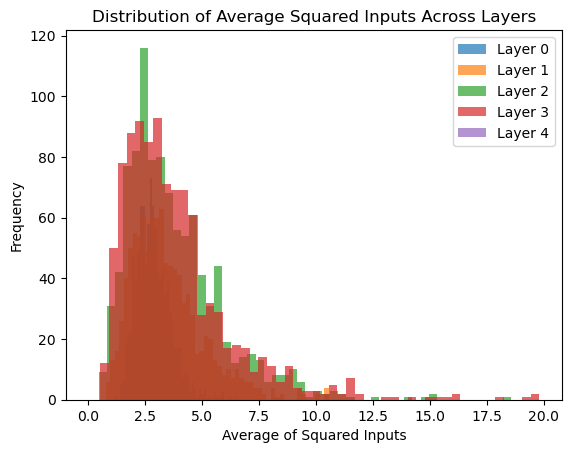

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class DeepFeedforwardNetwork(nn.Module):
    def __init__(self, num_layers, layer_size, sigma_w, sigma_b, activation_function=None):
        """
        Initializes the deep feedforward network.

        :param num_layers: Number of layers in the network (excluding input layer)
        :param layer_size: Number of neurons in each layer
        :param sigma_w: Standard deviation for weight initialization
        :param sigma_b: Standard deviation for bias initialization
        :param activation_function: Nonlinearity function (default is ReLU)
        """
        super(DeepFeedforwardNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.activation_function = activation_function or F.relu

        for _ in range(num_layers):
            layer = nn.Linear(layer_size, layer_size)
            nn.init.normal_(layer.weight, mean=0.0, std=sigma_w / (layer_size ** 0.5))
            nn.init.normal_(layer.bias, mean=0.0, std=sigma_b)
            self.layers.append(layer)

    def forward(self, x):
        """
        Performs forward propagation.

        :param x: Input tensor of shape (batch_size, input_size)
        :return: Output tensor after forward propagation
        """
        activations = []
        for layer in self.layers:
            x_linear = layer(x)  # Linear transformation (Wx + b)
            activations.append(x_linear)
            x = self.activation_function(x_linear)
        return x, activations
    
    
def compute_avg_squared_input(num_layers, layer_size, sigma_w, sigma_b, num_networks=1000, num_inputs=1000):
    squared_inputs = [[] for _ in range(num_layers + 1)]

    for _ in range(num_networks):
        model = DeepFeedforwardNetwork(num_layers, layer_size, sigma_w, sigma_b)
        inputs = torch.randn(num_inputs, layer_size)  # Standard normal distribution
        _, activations = model(inputs)
        for i, activation in enumerate(activations):
            mean_squared = torch.mean(activation ** 2, dim=0).mean().item()
            squared_inputs[i].append(mean_squared)

    return squared_inputs

# Parameters
num_layers = 4
layer_size = 10
sigma_w = 1.1
sigma_b = 1.3

# Compute distribution
avg_squared_inputs_distribution = compute_avg_squared_input(num_layers, layer_size, sigma_w, sigma_b)

# Plot the distribution for each layer
for i, data in enumerate(avg_squared_inputs_distribution):
    plt.hist(data, bins=50, alpha=0.7, label=f'Layer {i}')

plt.xlabel('Average of Squared Inputs')
plt.ylabel('Frequency')
plt.title('Distribution of Average Squared Inputs Across Layers')
plt.legend()
plt.show()


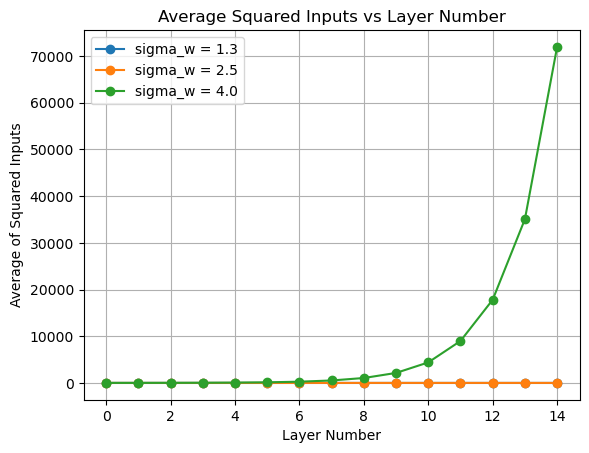

In [23]:
# Parameters
num_layers = 15
layer_size = 40
sigma_b = 0.3

# Function to compute average squared input per layer
def compute_avg_squared_input(num_layers, layer_size, sigma_w, sigma_b, num_networks=1000, num_inputs=1000):
    squared_inputs = torch.zeros(num_layers + 1)

    for _ in range(num_networks):
        model = DeepFeedforwardNetwork(num_layers, layer_size, sigma_w, sigma_b)
        inputs = torch.randn(num_inputs, layer_size)  # Standard normal distribution
        _, activations = model(inputs)
        for i, activation in enumerate(activations):
            squared_inputs[i] += torch.mean(activation ** 2)

    avg_squared_inputs = squared_inputs / num_networks
    return avg_squared_inputs


for i in [1.3,2.5,4.0]:
    # Compute distribution
    avg_squared_inputs_distribution = compute_avg_squared_input(num_layers, layer_size, sigma_w=i/2, sigma_b=sigma_b)
    # Plot results
    plt.plot(range(num_layers), avg_squared_inputs_distribution.cpu().detach().numpy()[:-1], marker='o', linestyle='-', label=f'sigma_w = {i}')
plt.xlabel('Layer Number')
plt.ylabel('Average of Squared Inputs')
plt.title('Average Squared Inputs vs Layer Number')
plt.legend()
plt.grid(True)
plt.show()


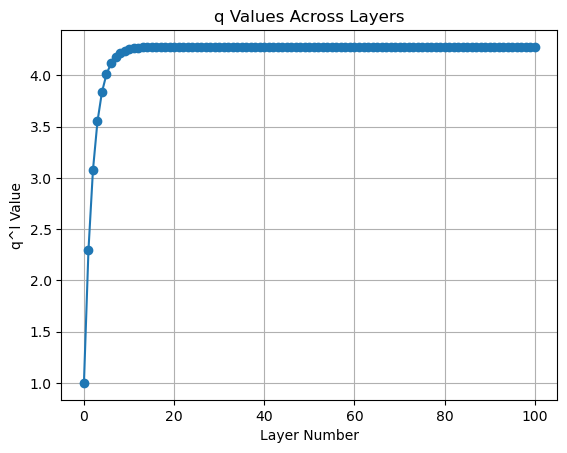

In [17]:
import numpy as np
from scipy.integrate import quad

def gaussian_measure(z):
    """Standard Gaussian measure."""
    return np.exp(-z**2 / 2) / np.sqrt(2 * np.pi)

def compute_q_layers(sigma_w, sigma_b, num_layers, activation_function=None):
    """
    Computes the sequence q^l given by:
    q^l = sigma_b^2 + sigma_w^2 * integral(phi(sqrt(q^{l-1}))^2 Dz)
    
    :param sigma_w: Weight standard deviation (σ_w)
    :param sigma_b: Bias standard deviation (σ_b)
    :param num_layers: Number of layers to compute
    :param activation_function: Activation function (default is ReLU)
    :return: List of q^l values for each layer
    """
    # Default activation function: ReLU
    if activation_function is None:
        activation_function = lambda x: np.maximum(0, x)
    
    def integral_function(q):
        """Function to compute integral of activation squared under Gaussian measure."""
        integrand = lambda z: activation_function(np.sqrt(q) * z)**2 * gaussian_measure(z)
        result, _ = quad(integrand, -np.inf, np.inf)
        return result

    # Initialize q values list
    q_values = [1]  # q^0 = σ_b^2

    for l in range(1, num_layers + 1):
        q_prev = q_values[-1]
        q_new = sigma_b**2 + sigma_w**2 * integral_function(q_prev)
        q_values.append(q_new)

    return q_values

# Example usage
sigma_w = 4
sigma_b = 0.3
num_layers = 100

q_values = compute_q_layers(sigma_w, sigma_b, num_layers)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(range(num_layers + 1), q_values, marker='o', linestyle='-')
plt.xlabel('Layer Number')
plt.ylabel('q^l Value')
plt.title('q Values Across Layers')
plt.grid(True)
plt.show()